In [2]:
required_packages <- c(
  "forecast",       # ARIMAX modeling
  "dplyr",          # Data manipulation
  "tidyr",          # pivot_wider/pivot_longer
  "prophet",        # xreg forecasting
  "thief",          # h
  "TSrepr",         # Errors
  "progress",
  "doParallel",
  "foreach",
  "randomForest"
)

# Install missing packages
new_packages <- required_packages[!required_packages %in% installed.packages()[,"Package"]]
if(length(new_packages)) install.packages(new_packages)

# Load all packages
invisible(lapply(required_packages, library, character.only = TRUE))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

Loading required package: rlang

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine




In [13]:
set.seed(42)

# Parametrai
n_series <- 50        # Kiek laiko eilučių generuoti
series_length <- 200  # Ilgis kiekvienai laikų eilutei

# Rezultatų saugykla
train_times <- data.frame(
  Modelis = character(),
  Laikas_s = numeric(),
  Serija = integer()
)

for (i in 1:n_series) {
  # Sukuriam sintetinius duomenis
  ts_data <- ts(rnorm(series_length, mean = 50, sd = 10), frequency = 7)
  
  # Naive
  t_naive <- system.time({
    model <- naive(ts_data)
  })[3]
  train_times <- rbind(train_times, data.frame(Modelis = "Naive", Laikas_s = t_naive, Serija = i))
  
  # ETS
  t_ets <- system.time({
    model <- ets(ts_data)
  })[3]
  train_times <- rbind(train_times, data.frame(Modelis = "ETS", Laikas_s = t_ets, Serija = i))
  
  # ARIMA
  t_arima <- system.time({
    model <- auto.arima(ts_data)
  })[3]
  train_times <- rbind(train_times, data.frame(Modelis = "ARIMA", Laikas_s = t_arima, Serija = i))
  
  # Random Forest – konstruojam požymius
  df <- data.frame(
    y = as.numeric(ts_data),
    x1 = lag(as.vector(ts_data), 1),
    x2 = lag(as.vector(ts_data), 2)
  )
  df <- na.omit(df)
  
  t_rf <- system.time({
    model <- randomForest(y ~ ., data = df)
  })[3]
  train_times <- rbind(train_times, data.frame(Modelis = "Random Forest", Laikas_s = t_rf, Serija = i))
}

# Suvestinė
summary_table <- train_times %>%
  group_by(Modelis) %>%
  summarise(Vidutinis_laikas_s = round(mean(Laikas_s), 3),
            SD_laikas = round(sd(Laikas_s), 3),
            .groups = "drop")

print(summary_table)

# A tibble: 4 × 3
  Modelis       Vidutinis_laikas_s SD_laikas
  <chr>                      <dbl>     <dbl>
1 ARIMA                      0.093     0.101
2 ETS                        0.31      0.033
3 Naive                      0.001     0    
4 Random Forest              0.087     0.003



Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




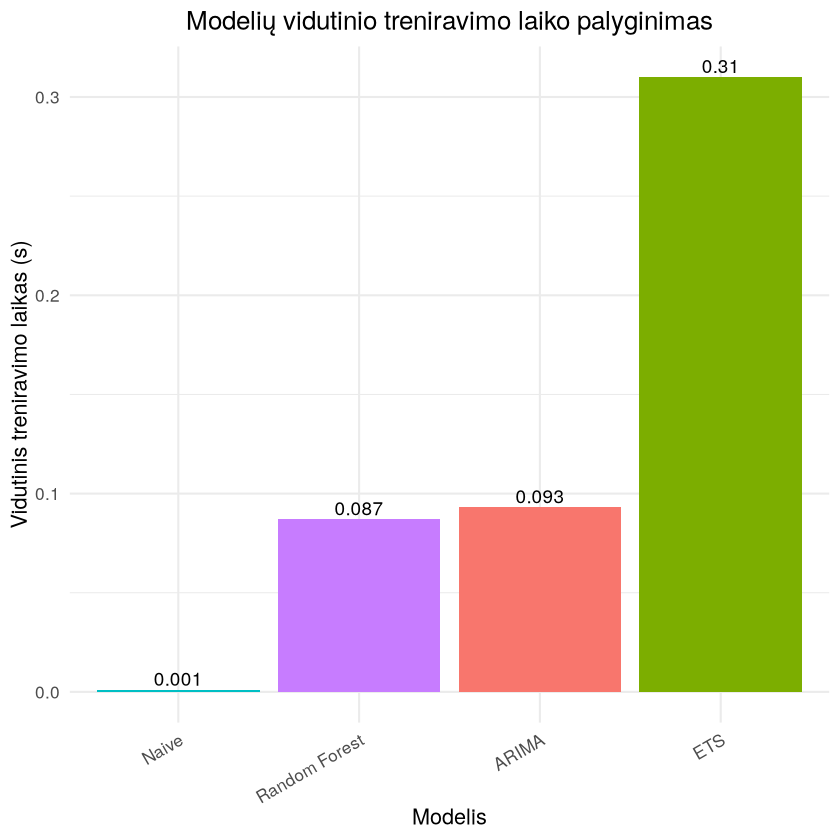

In [14]:
library(ggplot2)

# Naudojame ankstesnę suvestinę lentelę: summary_table
ggplot(summary_table, aes(x = reorder(Modelis, Vidutinis_laikas_s), y = Vidutinis_laikas_s, fill = Modelis)) +
  geom_col(show.legend = FALSE) +
  geom_text(aes(label = Vidutinis_laikas_s), vjust = -0.3, size = 4) +
  labs(
    title = "Modelių vidutinio treniravimo laiko palyginimas",
    x = "Modelis",
    y = "Vidutinis treniravimo laikas (s)"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(angle = 30, hjust = 1)
  )


In [15]:
ggsave("modeliu_treniravimo_laikai.png", width = 8, height = 5, dpi = 300)